# Dependencies



In [0]:
import pandas as pd
from datetime import datetime
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize


# Data Cleaning

In [0]:
stockRefDate = '2019-12-10'
stockTodayDate = datetime.today().strftime('%Y-%m-%d')
capital = 1e6

In [0]:
assets = ["UBER","ZM","GOOG","RTX","AMZN"]
#Social Media, Tech, Private transport
weights = {
  "UBER": 0.2,
  "ZM": 0.2,
  "GOOG": 0.2,
  "RTX": 0.2,
  "AMZN":0.2
}

In [0]:
dfTicker = pd.DataFrame()
for ticker in assets:
    dfTicker[ticker] = web.DataReader(ticker,'yahoo',stockRefDate,stockTodayDate)['Adj Close']

dfTickerNormReturn = pd.DataFrame()
for ticker in assets:
    dfTickerNormReturn[ticker] = dfTicker[ticker]/dfTicker[ticker][0]

dfTickerAllocation = pd.DataFrame()
for ticker in assets:
    dfTickerAllocation[ticker] = dfTickerNormReturn[ticker]*weights[ticker]

dfTickerPositionValue = pd.DataFrame()
for ticker in assets:
    dfTickerPositionValue[ticker] = dfTickerAllocation[ticker]*capital
dfTickerPositionValue['Total'] = dfTickerPositionValue.sum(axis = 1, skipna = True) 

In [19]:
dfTickerPositionValue

,UBER,ZM,GOOG,RTX,AMZN,Total
Date,,,,,,
2019-12-10,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,1.000000e+06
2019-12-11,203800.650400,196747.718005,200053.542954,202614.016645,201093.601115,1.004310e+06
2019-12-12,205736.831566,193557.385702,200834.409473,205558.222925,202428.688381,1.008116e+06
2019-12-13,204302.620255,196809.667697,200471.483021,205090.464050,202498.833488,1.009173e+06
2019-12-16,215489.421977,205513.392559,202455.640734,205627.015924,203449.842247,1.032535e+06
...,...,...,...,...,...,...
2020-05-04,196629.621200,444293.024994,197343.568650,129266.938118,266326.670414,1.233860e+06
2020-05-05,201290.787444,448567.470989,200959.343032,129596.423904,266534.817634,1.246949e+06
2020-05-06,199498.030144,463342.100186,200392.666485,127224.146359,270382.537195,1.260839e+06


## Position Value Visualization

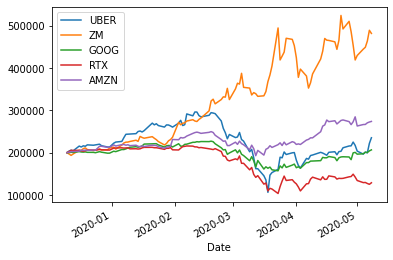

In [20]:
dfTickerPositionValue.drop('Total',axis=1).plot()
plt.show()

## Returns, Risk & Sharpe Ratio
Daily Returns = (P<sup>+</sup>- P)/(P)

In [0]:
dfTickerPositionValue['Returns Daily'] = dfTickerPositionValue['Total'].pct_change(periods=1)

In [0]:
portfolioAvgReturn = dfTickerPositionValue['Returns Daily'].mean()
portfolioStdDev = dfTickerPositionValue['Returns Daily'].std()
portfolioCummulativeReturn = ((dfTickerPositionValue['Total'][-1] / dfTickerPositionValue['Total'][0])-1)*100
riskFreeRate = 0
sharpeRatio = (portfolioAvgReturn-riskFreeRate)/portfolioStdDev
# Assuming 252 trading days in a year:
sharpeRatioAnnualized = math.sqrt(252)*sharpeRatio

In [23]:
print("The portfolio's cummulative return over the specified time period is: ", portfolioCummulativeReturn, "%.")
print("The annualized Sharpe Ratio is: ", sharpeRatioAnnualized, ".")

The portfolio's cummulative return over the specified time period is:  32.54915936887641 %.
The annualized Sharpe Ratio is:  1.8813353678990838 .


# Maximizing Sharpe Ratio

In [0]:
dfTickerLogReturn = np.log(dfTicker/dfTicker.shift(1))

dfTickerLogReturn.cov() will be a 5*5 matrix.

## Setup

In [0]:
numberOfPortfolios = 1000
weightsStore = np.zeros([numberOfPortfolios,len(dfTicker.columns)])
returnsStore = np.zeros(numberOfPortfolios)
volatilityStore = np.zeros(numberOfPortfolios)
sharpeRatioStore = np.zeros(numberOfPortfolios)
for i in range(numberOfPortfolios):
  weights = np.array(np.random.random(len(dfTicker.columns))) 
  weights = weights/np.sum(weights)  
  weightsStore[i,:] = weights
  returnsStore[i] = np.sum(dfTickerLogReturn.mean()*weights*252)
  expectedPortfolioVarianceAnnualized = np.dot(weights.T,np.dot(dfTickerLogReturn.cov()*252,weights))
  volatilityStore[i] = np.sqrt(expectedPortfolioVarianceAnnualized)
  sharpeRatioStore[i] = returnsStore[i]/volatilityStore[i]

## Monte Carlo Method

The best randomized portfolio (as seen from red dot in graph) is portfolio # 612 with weightage of [3.20559130e-04 3.88696608e-01 1.39882760e-01 2.87853769e-02
 4.42314695e-01] .
The maximum randomized sharpe ratio is 2.9615807483115177


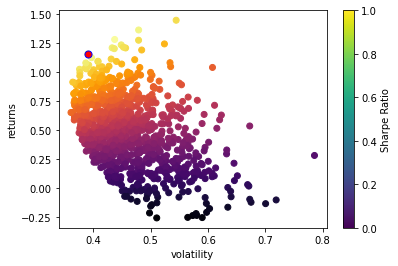

In [87]:
plt.scatter(volatilityStore,returnsStore,c=sharpeRatioStore,cmap='inferno')
plt.scatter(volatilityStore[sharpeRatioStore.argmax()], returnsStore[sharpeRatioStore.argmax()],c='red',s=50,edgecolors='blue')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('volatility')
plt.ylabel('returns')
print('The best randomized portfolio (as seen from red dot in graph) is portfolio #',sharpeRatioStore.argmax(),'with weightage of',weightsStore[sharpeRatioStore.argmax(),:],".")
print('The maximum randomized sharpe ratio is', sharpeRatioStore.max())

## Optimization Setup

In [86]:
constraints = ({'type': 'eq', 'fun': constraintsSum})
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
initialWeights = [0.2,0.2,0.2,0.2,0.2]

     fun: -3.235724725115919
     jac: array([ 3.56596380e-01,  6.21378422e-05,  8.04379791e-01,  2.33128673e+00,
       -5.43892384e-05])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.00000000e+00, 4.67178546e-01, 0.00000000e+00, 6.06843233e-16,
       5.32821454e-01])

## Optimization Method

In [0]:
def optimizerResults(constraints,bounds,initialWeights):

  def model(weights):
    weights=np.array(weights)
    modelReturns = np.sum(dfTickerLogReturn.mean()*weights*252)
    modelVariance = np.dot(weights.T,np.dot(dfTickerLogReturn.cov()*252,weights))
    modelVolatility = np.sqrt(modelVariance)
    modelSharpeRatio = modelReturns/modelVolatility  
    return modelReturns, modelVolatility, modelSharpeRatio

  def minSharpeRatio(weights):
    minSR = model(weights)[2]*-1
    return minSR

  def constraintsSum(weights):
    return np.sum(weights)-1

  optimalResults = minimize(minSharpeRatio,initialWeights,method='SLSQP', bounds=bounds,constraints=constraints)
  optimalWeights = optimalResults.x
  optimalReturns = model(optimalWeights)[0]
  optimalVolatiliy = model(optimalWeights)[1]
  optimalSharpeRatio = model(optimalWeights)[2]

  return optimalWeights, optimalReturns, optimalVolatiliy, optimalSharpeRatio

## Comparison between Sequential Least Squares optimization vs. simple monte carlo randomization method

In [88]:
print('The optimal sharpe ratio is',optimizerResults(constraints,bounds,initialWeights)[3],'which is HIGHER as compared to the monte carlo method sharpe ratio of',sharpeRatioStore.max(),'.')

The optimal sharpe ratio is 3.235724725115919 which is HIGHER as compared to the monte carlo method sharpe ratio of 2.9615807483115177 .
